In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1v969Oveo12TnTNI0ufgvKQKWYH2HzcMJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('trainX.zip')

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
import zipfile 
with zipfile.ZipFile('trainX.zip', 'r') as z:
  z.extractall()

In [ ]:
def load_data(path):
    x = np.load(path)
    x = (x / 255.0)*2-1
    return x   

In [ ]:
class autoencoder_dataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        img = self.transform(img)
        label = idx
        return img, label
    def __getimg__(self, idx):
        img = self.__getitem__(idx)[0]
        img = img.numpy().T
        img = ((img+1)/2)*255
        img = img.astype(np.uint8) 
        return Image.fromarray(img)   

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(                    #input (3,32,32)
            nn.Conv2d(3, 16, 5, stride=2, padding=1),   #(8,16,16)   
            nn.LeakyReLU(0.2),                     
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  #(16,8,8)
            nn.LeakyReLU(0.2),  
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3,2,1),                   #(32,4,4)
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),    
        )
        self.fc1 = nn.Linear(64*4*4,32)
        self.fc2 = nn.Linear(32,64*4*4)

        self.decoder = nn.Sequential(                    #input(32,2,2)
            nn.ConvTranspose2d(64, 32, 4, 2, 1),          #(32,8,8)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),         #output(16,8,8)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        xe = self.encoder(x)
        xe = xe.view(len(xe),-1)
        xe = self.fc1(xe)
        xd = self.decoder(self.fc2(xe).view(-1,64,4,4))
        return xe, xd

In [ ]:
train_X = load_data('trainX.npy')
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = autoencoder_dataset(train_X, transform)
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True)

model = autoencoder()
model.double()
model = model.cuda()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.001) 
loss_fn = nn.MSELoss()


num_epoch = 15

for epoch in range(num_epoch):
    for (img, ldx) in train_loader:
        img = img.cuda()
        optimizer.zero_grad()
        _, output = model(img)
        loss = loss_fn(output, img)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epoch, loss.item()))

epoch [1/15], loss:0.0652
epoch [2/15], loss:0.0791


In [ ]:
def latent(x):
    x = x.cpu().detach().numpy()
    return x

In [ ]:
test_loader = DataLoader(train_dataset, batch_size = 32)
predict = []
latentss = []
outputs = []
for img,_ in test_loader:
  img = img.cuda()
  encoder, output = model(img)
  outputs.append(latent(output))
  latentss.append(latent(encoder))
  predict += torch.max(output, 1)[1].tolist()
latentss = np.concatenate(latentss, axis=0)
latents = latentss.reshape([9000,-1])  
latents_mean = np.mean(latents, axis=1).reshape(9000,-1)
latents_std = np.std(latents, axis=1).reshape(9000,-1)
latents = (latents - latents_mean)/latents_std

In [ ]:
print(latentss[0].mean())
print(latents[0].mean())
print(latents_mean.shape)
print(latents.shape)

-0.08142972164714829
-2.7755575615628914e-17
(9000, 1)
(9000, 32)


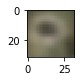

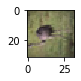

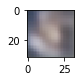

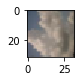

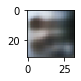

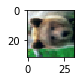

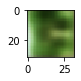

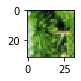

In [ ]:
import matplotlib.pyplot as plt
for i in range(4):
    a = output[-(i+1)].cpu()
    a = a.detach().numpy().T
    a = ((a+1)/2)*255
    a = a.astype(np.uint8)
    z = Image.fromarray(a)
    plt.subplot(4,2,(i+1)*2-1)
    plt.imshow(z)
    plt.show()    
    s = train_dataset.__getimg__(-(i+1))
    plt.subplot(4,2,(i+1)*2)
    plt.imshow(s)
    plt.show()

In [ ]:
from sklearn import manifold
import time
start = time.time()
tsne = manifold.TSNE()
tsne_x = tsne.fit_transform(latents)
print(time.time()-start)

98.11845469474792


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcax = pca.fit_transform(latents)
#pca2 = PCA(n_components=2)
#pcaxx = pca.fit_transform(pcax)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralCoclustering
result_tsne = KMeans(n_clusters=2).fit(tsne_x).labels_
#result_pca = KMeans(n_clusters=2).fit(pcax).labels_
#result = SpectralCoclustering(n_clusters = 2).fit(tsne_x).row_labels_

In [ ]:
result_tsne[:10]

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0], dtype=int32)

In [ ]:
submission = pd.DataFrame()
ids = np.arange(9000)
submission['id'] = ids
submission['label'] = result_tsne.reshape(9000,-1)
#submission.to_csv('predict.csv', index=False)
#from google.colab import files
#files.download('predict.csv')

In [ ]:
#submission['label'] = submission['label'].map(lambda x : abs(x-1))
submission.to_csv('predict.csv', index=False)
from google.colab import files
files.download('predict.csv')

In [ ]:
submission.head(10)

,id,label
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1
5,5,0
6,6,1
7,7,0
8,8,0
9,9,1


In [ ]:
!cd

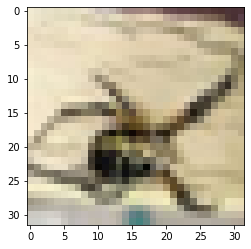

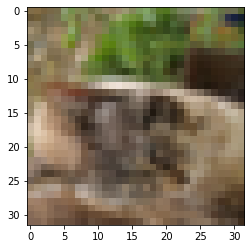

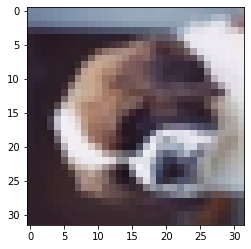

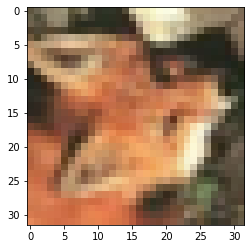

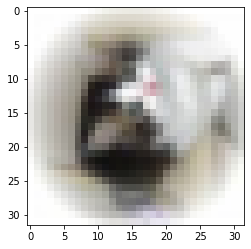

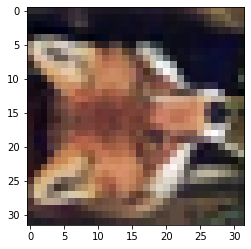

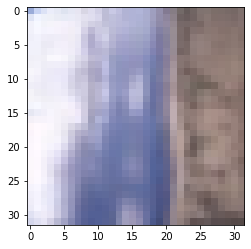

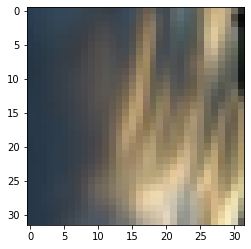

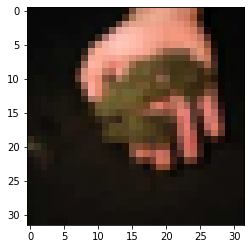

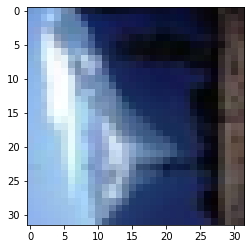

In [ ]:
for i in range(10):
    s = train_dataset.__getimg__(i)
    plt.imshow(s)
    plt.show()